In [16]:
import pandas as pd
import numpy as np
import yaml
import numpy
import time
from IPython.display import clear_output
import warnings
import re
import joblib
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
warnings.filterwarnings('ignore')

# Categorisation Module

In [2]:
#base_features = config['base_feats']
#label = config['label_class']
df = pd.read_csv('dataframe.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('baseTotal', axis=1)

In [157]:
df.head()

,total,mcc,baseCurrency,date,currency,merchant
0,5.00,5993.0,EUR,2019-02-14 10:42:29.195,EUR,ESTANCO HERNAN
1,2.90,5814.0,EUR,2019-02-21 08:31:30.714,EUR,STARBUCKS COFFEE
2,12.00,5812.0,EUR,2019-03-05 12:22:16.925,EUR,FARO FINISTERRE
3,15.00,NaN,EUR,2019-03-06 23:00:00.000,CHF,Migros
4,3.45,5812.0,EUR,2019-03-13 07:44:45.235,EUR,VIRREY SAN


In [159]:
def transform_merchant_field(data_frame):
    """ Cleans the merchant field with regular expressions
    """
    clean_regexp_list = []
    clean_regexp_list.append((re.compile(r"^CRV\*.*London\s+GBR$"),
                              [re.compile("^CRV\*"),
                               re.compile("London\s+GBR$")]))
    clean_regexp_list.append((re.compile("^C-[a-zA-Z0-9]+\s+from\s+Curv$"),
                              [re.compile(r"^C-[a-zA-Z0-9]+\s+from")])) 
    new_merchant_list = []
    for _merchant in data_frame["merchant"]:
        _merchant = str(_merchant) 
        for _reg in clean_regexp_list:
            if _reg[0].match(_merchant):
                for _sub in _reg[1]:
                    _merchant = _sub.sub("", _merchant)

        new_merchant_list.append(_merchant)
    data_frame.loc[:, "merchant"] = new_merchant_list
    return data_frame

df = transform_merchant_field(df)

In [160]:
import numpy as np
def levenshtein_ratio_and_distance(s, t):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        This helps in determining if two close strings do represent the same
        See example below
    """
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)
    ratio_calc = True
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 
            else:
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,     
                                 distance[row][col-1] + 1,          
                                 distance[row-1][col-1] + cost)
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio

In [154]:
s1 = 'ZITY Madrid ESP'
s2 = 'ZITY Inc'
levenshtein_ratio_and_distance(s1,s2)

0.43478260869565216

In [157]:
df[df['month-day'] == '10-17']['merchant'].value_counts()

ZITY Madrid ESP                     9
Card verification                   2
LA VAQUERIA MONTA ESA MADRID ESP    1
SQ *LUM                             1
TAXI 04905 JULIAN ALCORCON ESP      1
ZEPLIN INC SAN FRANCISCO CA         1
CRUSTO SL MADRID ESP                1
 Curv                               1
Name: merchant, dtype: int64

In [3]:
df['date'] = df['date'].apply(lambda x : x[:10])
df['month-day'] = df['date'].apply(lambda x : x[5:])
df['month-year'] = df['date'].apply(lambda x : x[:7])
df['year'] = df['date'].apply(lambda x : int(x[0:4]))
df['month'] = df['date'].apply(lambda x : int(x[5:7]))
df['day'] = df['date'].apply(lambda x : int(x[8:]))
comb = 4.58

In [126]:
#df['merchant'][:50]

In [ ]:
m_d_combinations = []
for m_d, count in zip(df['month-day'].value_counts().index, df['month-day'].value_counts()):
    if count > 2 :
        m_d_combinations.append(m_d)

In [163]:
recurrent_merchants = []
for m_d in m_d_combinations:
        _ = df[df['month-day'] == m_d]['merchant']
        for merchant, count in zip(_.value_counts().index, _.value_counts()):
            if count > 1:
                    recurrent_merchants.append(merchant)

In [196]:
recurrent_merchants

['ZITY Madrid ESP',
 'Card verification',
 'Card verification',
 'CRV* Curve',
 'SQ *LUM',
 ' Curv',
 'HOTEL CJ1 MURCIA',
 'Ferrovial Servicios SA',
 'Card verification',
 'CRV* Curve',
 'ALCAMPO28029-VAGUADA MADRID ESP',
 'ZITY Madrid ESP',
 'UberBV help.uber.com NLD',
 'ZITY Madrid ESP',
 'Card verification',
 'Zity',
 'UBER TRIP HELP.UBER.CO help.uber.com NLD',
 'THE JUGGED HARE',
 'UBER TRIP HELP.UBER.CO help.uber.com NLD',
 'STARBUCKS COFFEE CALLA MADRID ESP',
 'HOTEL RAMBLAS BARCELONA ESP',
 'UBER TRIP HELP.UBER.CO help.uber.com NLD',
 'ZITY Madrid ESP',
 'UberBV',
 'SQ *LUM London GBR',
 'UBER TRIP HELP.UBER.CO help.uber.com NLD',
 'UberBV help.uber.com NLD',
 'WWW.SAGE.COM EUR NEWCASTLE UPO GBR',
 'SQ *LUM',
 'SQ *LUM',
 'UberBV help.uber.com NLD',
 'INTERCOM IO SAN FRANCISCO CA',
 'Card verification',
 'ONLY YOU HOTEL ATOCHA MADRID ESP',
 'UberBV help.uber.com NLD',
 'CRV* Curve',
 'INTERCOM IO SAN FRANCISCO CA',
 'ZITY Madrid ESP',
 'UBER TRIP HELP.UBE',
 'UBER TRIP HELP.UBER

In [231]:
datetime.datetime.strptime('01/2019', '%m/%Y')

datetime.datetime(2019, 1, 1, 0, 0)

In [233]:
from dateutil import parser
parser.parse("01/2019")

datetime.datetime(2019, 1, 12, 0, 0)

In [322]:
df[df.merchant == 'ATLASSIAN ATLASSIAN'][df.day==12].loc[:,['total', 'month-year']]

/Users/Javier/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,total,month-year
104,20.000,2019-08
126,10.000,2019-09
235,10.000,2019-11
283,15.000,2019-12
302,15.000,2020-01
343,26.995,2020-02
397,15.000,2019-10
432,10.000,2019-07


### Revenue Generation :
Since the revenues were not provided, arbitrary values are given following a simple rule to simplify experiment.

In [4]:
#Generates sequential revenues used for comparison
revenue = {}
count = 1000
increment = 500
for m_y in df['month-year'].unique():
    count += increment
    revenue[m_y] = count
revenue

{'2019-02': 1500,
 '2019-03': 2000,
 '2019-05': 2500,
 '2019-06': 3000,
 '2019-07': 3500,
 '2019-08': 4000,
 '2019-09': 4500,
 '2019-10': 5000,
 '2019-11': 5500,
 '2019-12': 6000,
 '2020-01': 6500,
 '2020-02': 7000}

In [5]:
epsilon_list = [.01, .03, .06, .1, .5, 1]
df['variability'] = -1
df.head()

,total,mcc,baseCurrency,date,currency,merchant,month-day,month-year,year,month,day,variability
0,5.00,5993.0,EUR,2019-02-14,EUR,ESTANCO HERNAN,02-14,2019-02,2019,2,14,-1
1,2.90,5814.0,EUR,2019-02-21,EUR,STARBUCKS COFFEE,02-21,2019-02,2019,2,21,-1
2,12.00,5812.0,EUR,2019-03-05,EUR,FARO FINISTERRE,03-05,2019-03,2019,3,5,-1
3,15.00,NaN,EUR,2019-03-06,CHF,Migros,03-06,2019-03,2019,3,6,-1
4,3.45,5812.0,EUR,2019-03-13,EUR,VIRREY SAN,03-13,2019-03,2019,3,13,-1


#### Computing variability scores

In [10]:
#Assigns the variability values depending on the elasticity
for m, c in zip(df.merchant.value_counts().index, df.merchant.value_counts()):
    if c > 1:
        _ = df[df.merchant == m]
        for d in _.day.unique():
            _df = _[df.day==d].loc[:,['total', 'month-year']]
            if _df.shape[0] > 1 :
                total = _df['total']
                #print(total)
                m_y = _df['month-year']
                elasticity = get_elasticity(total, m_y)
                variability = comput_variability(elasticity)
                inds = df[df.merchant==m].index 
                df.loc[inds, 'variability'] = variability
print(df.variability.value_counts())

-1    237
 2     68
 3     59
 1     46
 0     41
 5      6
 4      5
Name: variability, dtype: int64


In [7]:
def compute_elasticity(cost1, cost2, date1, date2):
    diff_cost = np.absolute(cost2-cost1)
    rev1 = revenue[date1]
    rev2 = revenue[date2]
    diff_rev = np.absolute(rev2-rev1)
    elasticity = diff_cost * rev2 / (diff_rev * cost2)
    return elasticity

def get_elasticity(cost, date):
    for i in range(len(cost)):
        j = np.min([i+1, len(cost)-1])
        c1 = cost.iloc[i]
        c2 = cost.iloc[j]
        d1 = date.iloc[i]
        d2 = date.iloc[j]
        if len(cost) < 3 :
            elasticity = compute_elasticity(c1,c2,d1,d2)
            return elasticity
        #If there are more than two transactions make average
        else:
            elasticity_list = []
            elasticity_list.append(compute_elasticity(c1,c2,d1,d2))
            avg = np.sum(elasticity_list) / len(elasticity_list)
            return avg
        
def compute_variability(elasticty):
    variability = -1
    for ind in range(len(epsilon_list)):
        eps = epsilon_list[ind]
        if elasticity < eps:
               variability = ind
        return variability

In [400]:
df['merchant'].value_counts()

ZITY Madrid               23
UBER TRIP                 21
SQ *LUM                   21
ATLASSIAN ATLASSIAN       15
Card verification         15
                          ..
easyJet EZ73XNG-718350     1
Swiss International        1
SUPERMERCADO SANCHEZ       1
VAQUERIA MONTA             1
TAXI 9959                  1
Name: merchant, Length: 213, dtype: int64

#### Labeling :
It's partly based-rule as explained in paper, but then manually adjusted

In [11]:
#labelling
df['label'] = 'periodic'
_ = df[(df.variability < 2) & (df.variability > -1)].index
df.loc[_, 'label'] = 'fixed'
_ = df[df.variability > 2].index
df.loc[_, 'label'] = 'variable'

In [12]:
#Distribution of labels purely based-rule. Then manually changing the ones causing errors
df.label.value_counts()

periodic    305
fixed        87
variable     70
Name: label, dtype: int64

In [18]:
df = df.replace(np.nan, '', regex=True)

In [265]:
def vectorize_merchant(data_frame, path_glove):
    """ Vectorize the merchant fields into several features
    """
    word_dict = joblib.load(path_glove)
    topic_vector_list = []
    if 'merchant' in data_frame:
        for name in data_frame["merchant"]:
            data_frame = data_frame.replace(np.nan, '', regex=True)
            topic_word_dict = OrderedDict()
            name_parts = name.lower().split(" ")
            for part in name_parts:
                if part in word_dict:
                    for topic in word_dict[part]:
                        new_topic = "Text_{}".format(topic)
                        if new_topic not in topic_word_dict:
                            topic_word_dict[new_topic] = 0
                        topic_word_dict[new_topic] += word_dict[part][topic]
            total_topic = np.sum([topic_word_dict[new_topic] for new_topic in topic_word_dict])
            t_1 = np.random.normal(loc=2, scale=3, size=35)
            t_2 = np.random.normal(loc=comb, scale=2, size=45)
            t_3 = np.random.normal(loc=comb, scale=1, size=20)
            avg = np.concatenate([t1,t2,t3])
            if total_topic > 0:
                for topic in topic_word_dict:
                    topic_word_dict[topic] /= total_topic
            topic_vector_list.append(topic_word_dict)
        data_frame.loc[:, "Text"] = topic_vector_list
        data_frame = data_frame.drop('Text', 1).assign(
            **pd.DataFrame(data_frame.Text.values.tolist()).astype("float32").fillna(0.0))
        data_frame = data_frame.sample(frac=1).reset_index(drop=True)
        print("Dataframe Type", data_frame.dtypes)
    print("Dataframe(Head)", data_frame.head(10))
    return data_frame, avg

In [22]:
path = 'glove'
df, avg = vectorize_merchant(df, path)

Dataframe Type total           float64
mcc              object
baseCurrency     object
date             object
currency         object
                 ...   
Text_833        float32
Text_834        float32
Text_835        float32
Text_59         float32
Text_763        float32
Length: 834, dtype: object
Dataframe(Head)    total   mcc baseCurrency        date currency              merchant  \
0  20.00  5734          EUR  2019-11-28      EUR      WWW.SAGE.COM EUR   
1  15.85  4121          EUR  2019-10-17      EUR            TAXI 04905   
2   1.50  7372          GBP  2020-02-10      GBP               SQ *LUM   
3  10.70  4121          EUR  2019-11-25      EUR              TAXI LIC   
4  17.60  4121          EUR  2020-02-12      EUR           LICENCIA 77   
5  24.62  4121          GBP  2019-09-17      EUR             UBER TRIP   
6   3.20  5812          EUR  2019-12-02      EUR   CENTRO GASTRONOMICO   
7  -1.19  4121          EUR  2019-12-09      GBP  UberBV help.uber.com   
8 -17.76  41

In [48]:
data = df

#### Before Encoding :
Afterwards data is completely discretised (and not really understandable)

In [53]:
data = data.drop(['month-year', 'month-day', 'year', 'month', 'day'], axis=1)
data.head(5)

,total,mcc,date,currency,variability,label,Text_264,Text_275,Text_343,Text_131,...,Text_816,Text_817,Text_818,Text_256,Text_819,Text_833,Text_834,Text_835,Text_59,Text_763
0,20.00,5734,2019-11-28,EUR,3,variable,0.000000,0.058824,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15.85,4121,2019-10-17,EUR,3,variable,0.005764,0.002882,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.50,7372,2020-02-10,GBP,-1,periodic,0.133333,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.70,4121,2019-11-25,EUR,0,fixed,0.002882,0.063941,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17.60,4121,2020-02-12,EUR,-1,periodic,0.026316,0.093170,0.0,0.001548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [161]:
#df = df.drop(['merchant', 'baseCurrency'], axis=1)
df = data
y = df['label']
X = df.drop(['label'], axis=1)

#Covering problematic missing mccs
_ = X.mcc[X.mcc==''].index
X.loc[_, 'mcc'] = 0

#Remaining Preprocessing
y = LabelEncoder().fit_transform(y)
X.currency = LabelEncoder().fit_transform(X.currency)
X.date = LabelEncoder().fit_transform(X.date)
#X = X.fillna(-1)
#X = pd.concat(X.drop(['mcc', 'date'], axis=1), OneHotEncoder().fit_transform(X.loc[:,['mcc','date']]))
#X = OneHotEncoder(categories='auto').fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((309, 826), (153, 826), (309,), (153,))

### Classification :

In [ ]:
models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'NaiveBayes' : GaussianNB(),
}

# the optimisation parameters for each of the above models
params = {
    'RandomForestClassifier':{ 
            "n_estimators"      : [100, 200, 500, 1000],
            "max_features"      : ["auto", "sqrt", "log2"],
            "bootstrap": [True],
            "criterion": ['gini', 'entropy'],
            "oob_score": [True, False]
            },
    'LogisticRegression': {
        'solver': ['newton-cg', 'sag', 'lbfgs'],
        'multi_class': ['ovr', 'multinomial']
        }, 
    'NaiveBayes': { },
}

In [ ]:
from sklearn.model_selection import GridSearchCV

def fit(train_features, train_actuals):
        """
        Fits the list of models and reports the best estimators in each turn of the loop
        """
        best_models = []
        for name in models.keys():
            est = models[name]
            est_params = params[name]
            gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=5)
            gscv.fit(train_features, train_actuals)
            best_models.append(gscv.best_estimator_)
        return best_models

In [142]:
df = df.replace(np.nan, '', regex=True)

In [194]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [81]:
from yellowbrick.model_selection import LearningCurve

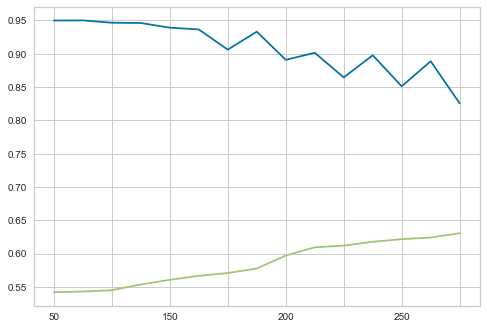

In [231]:
nb = GaussianNB(priors=None, var_smoothing=1e-09)
visualizer = LearningCurve(
    nb, cv=cv, scoring='accuracy', train_sizes=sizes, n_jobs=4, train_color='orange'
)
visualizer.fit(X_train, y_train)
visualizer.show()

In [204]:
y_train_pred = nb.predict(X_train)
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_pred)
print("Train Accuracy {}\nTest Accuracy {}".format(accuracy_score(y_train, y_train_pred), 
                                                accuracy_score(y_test, y_pred))

Train Accuracy 0.8480550161812298
Test Accuracy 0.655921568627451


In [190]:
from sklearn.metrics import confusion_matrix
from metrics import f1_score
nb = GaussianNB(priors=None, var_smoothing=1e-09)
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
confusion_matrix(y_test, y_pred)
print('Confusion Matrix :\n{}'.format(confusion_matrix(y_test, y_pred)))

Confusion Matrix :
[[13.  3.  8.]
 [ 6. 17.  4.]
 [ 9.  0. 27.]]


# Optimization Module

In [4]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
import random
from IPython.display import clear_output
import math

#### Config :
Those are the values used for the experiment (same as in paper) as they are simpler.
In a functional script there would be a transition from the costs classified in the previous part to generating automatically this config with the various different costs

In [7]:
config = {'fixed': 4,
          'periodic': 2,
          'variable': [1, 3],
          'weights': [1.35, 3.2],
          'revenue': 10,
          'rev_bounds': [11, 21, 31], #for discretisation of statespace
          'cost_bounds': 10 #upper-bound of costs for this experiment
}

In [5]:
class environment(gym.Env):
    metadata = {'render.modes': ['human']}

    down = 0
    up = 1
    
    def __init__(self, config):
        
        self.fixed = config['fixed']
        self.periodic = config['periodic']
        self.variable_costs = config['variable']
        self.revenue = config['revenue']
        self.weights = config['weights']
        self.cost_bounds = config['cost_bounds']
        self.rev_bounds = config['rev_bounds']
        
        self.len = len(self.variable_costs)
        self.action_space = self.generate_actions()
        self.state_space = self.generate_state_space()
        self.profit = self.revenue-self.fixed+self.periodic+sum(self.variable_costs)
        
        #Factors used for en/decoding functions
        self.factors = self.generate_encoding_factors()
        self.current_state = self.encode(self.variable_costs, self.check_rev_bounds(self.revenue))
    
    #Agent takes one step in decision process
    def step(self, action):
        new_state = self.take_action(action)
        self.current_state = new_state
        reward, flag = self.get_reward()
        
        if flag is not True:
            flag = self.reset()
        
        return new_state, reward, flag
    
    def reset(self):
        self.fixed = config['fixed']
        self.periodic = config['periodic']
        self.variable_costs = config['variable']
        self.revenue = config['revenue']
        self.update_profit()
        return True
    
    #Arbitrary reward definition. Good convergence is observed for this one
    def get_reward(self):
        flag = True
        reward = -0.1
        if self.profit >= 10:
            reward = 10
            flag = False
        return reward, flag
        
    def generate_actions(self):
        actions = {}
        a_names = ["increase", "decrease"]
        for i in range(0, self.len*2):
                a = a_names[i%2]
                actions[i] = "{} {}".format(a, i//2)
        print("Action Space : {} ".format(actions))
        return actions
    
    #State space is the combination of all possible states
    # -> Multiplying the quantities of values each costs, and revenue, can take
    def generate_state_space(self):
        state_space = 1
        for i in range(self.len):
            state_space *= self.cost_bounds
        state_space *= len(self.rev_bounds)
        print("State Space : {} combinations for current experiment".format(state_space))
        return state_space
    
    def update_profit(self):
        self.profit = self.revenue-self.fixed+self.periodic+sum(self.variable_costs)
        return


    def take_action(self, action):
        # The floor // operations translates which action belongs to each cost
        action = self.action_space[action]
        cost = int(action.split()[1])
        #print(cost)
        weight = self.weights[cost]
        #print(action)
        if action.split()[0] == 'increase':
            new_cost, flag = self.get_cost_bounds(self.variable_costs[cost], 1)
            self.variable_costs[cost] = new_cost
            if flag :
                self.revenue += weight
        elif action.split()[0] == 'decrease':
            new_cost, flag = self.get_cost_bounds(self.variable_costs[cost], -1)
            self.variable_costs[cost] = new_cost
            if flag :
                self.revenue -= weight
        else:
            pass
        
        revenue_cat = self.check_rev_bounds(self.revenue)
        #print("----")
        print("\n--> {}".format(action))
        for i in range(self.len):
            print("V{} : {} \ ".format(i,self.variable_costs[i]), end='')
        print("\nRev : {}".format(self.revenue))
        total_c = self.periodic+self.fixed+sum(self.variable_costs)
        print("(Total Costs : {})".format(total_c))
        self.update_profit()
        print("Profit : {}\n------".format(self.profit))
              
        return self.encode(self.variable_costs, revenue_cat)

    def get_cost_bounds(self, cost, change):
        flag = True
        if change > 0 :
            cost = np.min([cost+change, 10])
            if cost == 10:
                flag = False
                
        elif change < 0:
            cost = np.max([cost+change, 0])
            if cost == 0:
                flag = False
                    
        return cost, flag

    def check_rev_bounds(self, revenue):
            for i in range(len(self.rev_bounds)):
                if revenue < self.rev_bounds[i]:
                    return i
            return 0

    def generate_encoding_factors(self):
        factors = [1]
        factors.append(len(self.rev_bounds))
        factors.append(self.cost_bounds*len(self.rev_bounds) + len(self.rev_bounds))
        #Only for two variable costs in this case. Additional combinations for more
        return factors

    #Encodes format (cost0, cost1 ... costn, rev) into an index for q_table
    def encode(self, variable_costs, revenue_cat):
        state = 0
        state += revenue_cat * self.factors[0] + 1
        variable_costs = variable_costs[::-1]
        for i in range(self.len):
            state += variable_costs[i] * self.factors[i+1]
        return np.min([state, self.state_space-1])

    def decode(self, state):
        variable_costs = []
        factors = self.factors[::-1]
        for i in range(self.len):
            variable_costs.append(state//(factors[i]+1))
            state = state % (factors[i]+1)
        revenue = np.max([state, 0])
        return variable_costs, revenue

#### Example of random agent :
How a random agent plays the game, it can take hours (or minutes, as it is random) to reach a goal.
It illustrates how the different values are meant to fluctuate given the assumptions

In [235]:
env = environment(config)
for i in range(5):
        a = random.choice([0,1,2,3])
        env.step(a)
        #clear_output(wait=True)

Action Space : {0: 'increase 0', 1: 'decrease 0', 2: 'increase 1', 3: 'decrease 1'} 
State Space : 300 combinations for current experiment

--> increase 1
V0 : 1 \ V1 : 4 \ 
Rev : 13.2
(Total Costs : 11)
Profit : 16.2
------

--> increase 0
V0 : 2 \ V1 : 4 \ 
Rev : 11.35
(Total Costs : 12)
Profit : 15.35
------

--> decrease 0
V0 : 1 \ V1 : 4 \ 
Rev : 8.65
(Total Costs : 11)
Profit : 11.65
------

--> decrease 1
V0 : 1 \ V1 : 3 \ 
Rev : 6.8
(Total Costs : 10)
Profit : 8.8
------

--> decrease 1
V0 : 1 \ V1 : 2 \ 
Rev : 3.5999999999999996
(Total Costs : 9)
Profit : 4.6
------


### Encoder / Decoder
A bit technical, but really important in order to translate the states understood by environment under the form (cost1, cost2 ... costn, revenue) into indexes can be fed directly to the q_table (see paper)

In [236]:
_ = environment(config)
clear_output(wait=True)
print("V0 : {} \ V1: {}  \ Revenue : {}".format(1, 0, 2))
st = _.encode([1, 0], 2)
print("Encoded --> State {}".format(st))

print("\nState {}".format(_.encode([1,0], 2)))
c, r = _.decode(36)
print("Decoded --> V0 : {} \ V1: {}  \ Revenue : {}\n".format(c[0], c[1], r))
#print(_.encode())

print("V0 : {} \ V1: {}  \ Revenue : {}".format(0, 0, 0))
st = _.encode([0, 0], 0)
print("Encoded --> State {}".format(st))

V0 : 1 \ V1: 0  \ Revenue : 2
Encoded --> State 36

State 36
Decoded --> V0 : 1 \ V1: 0  \ Revenue : 2

V0 : 0 \ V1: 0  \ Revenue : 0
Encoded --> State 1


In [12]:
class Q_Agent:
    
    def __init__(self):
        self.env = environment(config)
        self.q_table = np.zeros([self.env.state_space, len(self.env.action_space)])
        #self.mdp_tuple = self.env.define_mdp_tuple()
    
    #Training is epsilon_greedy for this experiment
    def train(self, episodes, epsilon, alpha, gamma):
        state = self.env.current_state
        for i in range(episodes):
            done = False
            while not done:
                clear_output(wait=True)
                print("Training.... Episode {}".format(i))
                if random.uniform(1,0) < epsilon:
                    action = random.choice(list(self.env.action_space.keys()))
                else :
                    action = np.argmax(self.q_table[state])
                
                next_state, reward, done = self.env.step(action)
                
                old_value = self.q_table[state, action]
                next_max = np.max(self.q_table[next_state])
                
                new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
                self.q_table[state, action] = new_value
                
                state = next_state
                
    def evaluate(self, episodes):
        self.env.reset()
        state = self.env.current_state
        total_epochs = 0
        cumulated_reward_list = []
        avg_reward = []
        for i in range(episodes):
            done = False
            epochs = 0
            #print("Episode : {}".format(i+1))
            while not done :
                clear_output(wait=True)
                action = np.argmax(self.q_table[state])
                next_state, reward, done = self.env.step(action)
                state = next_state
                epochs +=1
                print("Epoch : {}".format(epochs))
            #Accuracy    
            if (episodes + 1) - i <= 100:
                sum_reward = sum(cumulated_reward_list)/epochs
                avg_reward.append(reward)

        print("Total episodes : {}".format(episodes))
        print("Average timesteps per episode : {}".format(total_epochs/episodes))
        return print("\nFinal average reward : {}".format(avg_reward[-1])), plt.plot(avg_rewards)

#### Training and evaluation
How a q-learning agent is trained to reach a goal (only 100 episodes here). Results can vary a lot since its a stochastic process but the intuition of the reward converging to a value is here


--> increase 0
V0 : 10 \ V1 : 6 \ 
Rev : 10
(Total Costs : 22)
Profit : 24
------
Epoch : 1
Total episodes : 100
Average timesteps per episode : 18.34567945

Final average reward : 4.46740866


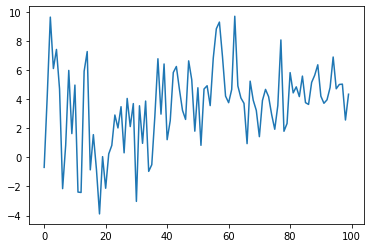

In [17]:
q = Q_Agent()
episodes = 100
alpha = 0.3
gamma = 0.6
epsilon = 0.1
q.train(episodes, epsilon, alpha, gamma)
q.evaluate(100)

#### Random Agent measures :
Can very a lot due to randomness, but in avg it is slower than a pre-trained agent

In [40]:
env_ = environment(config)
accumulated_reward = []
epochs = 1
flag = False
for i in range(100):
        flag = False
        while not flag:
            clear_output(wait=True)
            a = random.choice([0,1,2,3])
            _, reward, flag = env_.step(a)
            accumulated_reward.append(reward)
            epochs += 1
print("Total episodes : {}".format(episodes))
print("Average timesteps per episode : {}".format(epochs/episodes))
print("\nFinal average reward : {}".format(sum(accumulated_reward)/episodes))


--> increase 0
V0 : 7 \ V1 : 8 \ 
Rev : 11.35
(Total Costs : 21)
Profit : 24.35
------
Total episodes : 100
Average timesteps per episode : 1223

Final average reward : -3.4539012
